In [1]:
!pip install mnist

In [2]:
import numpy as np
import mnist
import matplotlib.pyplot as plt
import pickle
from hw2 import get_mnist_threes_nines, display_image
%matplotlib inline
import sys
# np.set_printoptions(threshold=sys.maxsize)

(28, 28)

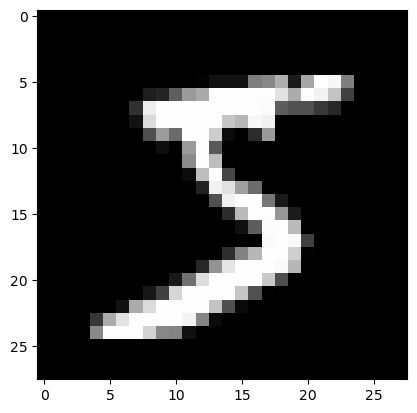

In [3]:
display_image(mnist.train_images()[0])
np.shape(mnist.train_images()[0])

<b>1.2a<b> (finite differences checker, used to help implement `my_nn_finite_difference_checker` in 1.3a. Feel free to modify the function signature, or to skip this part and implement `my_nn_finite_difference_checker` without this helper function.)

In [4]:
def finite_difference_checker(f, x, i, j):
    """Returns \frac{\partial f}{\partial x_k}(x)"""
    # YOUR CODE HERE
    v = np.zeros_like(x)
    v[k] = 1
    x1 = x + (10**-5)*v
    x2 = x - (10**-5)*v
    derivative = (f(x1)-f(x2))/(2*(10**-5))
    return derivative


1.2b (functions that implement neural network layers)

In [20]:
def sigmoid_activation(x):
    # YOUR CODE HERE
    # return: output of activation function, gradient of function
    # array of same shape as the input
    # Q：vectorize numerically stable version, np.where
    ep = (10**-15)
    z = np.zeros_like(x)
    out = np.where(x>=0, 1/(1+np.exp(-x,out=z,where=x>=0)), np.exp(x,out=z,where=x<0)/(1+np.exp(x,out=z,where=x<0)))
    out = np.where(out>=1-ep, 1-ep, out)
    out = np.where(out<=ep, ep, out)
    grad = out * (1-out)
    return out, grad

def logistic_loss(g, y):
    """
    Computes the loss and gradient for binary classification with logistic
    loss

    Inputs:
    - g: Output of final layer with sigmoid activation,
         of shape (n, 1) 

    - y: Vector of labels, of shape (n,) where y[i] is the label for x[i] 
         and y[i] in {0, 1}

    Returns a tuple of:
    - loss: array of losses
    - dL_dg: Gradient of the loss with respect to g
    """
    # YOUR CODE HERE
    g = g.reshape(-1)
    loss = -np.log(g**y*(1-g)**(1-y))
    dL_dg = -(np.divide(y,g)+np.divide(1-y,1-g))
    # shape will be (n,)
    dL_dg = dL_dg.reshape(-1, 1) # reshaping it to be (n,1)
    return loss, dL_dg

def relu_activation(s):
    # YOUR CODE HERE
    out = np.where(s<0,0,s)
    ds = np.where(s<0,0,1)
    return out, ds

def layer_forward(x, W, b, activation_fn):
    # YOUR CODE HERE
    out, ds = activation_fn(x@W+b)
    cache = (x, W, b, ds)
    return out, cache


1.3b i, ii (deliverables for the sigmoid activation)

In [21]:
# 1.3b i
s = np.asarray([1., 0., -1])
out, grad = sigmoid_activation(s)
with np.printoptions(precision=2):
    print(out)
    print(grad)
    
print("="*80)

# 1.3b ii
s = np.asarray([-1000., 1000.])
out, grad = sigmoid_activation(s)
print(out)
print(grad)

[0.73 0.5  0.27]
[0.2  0.25 0.2 ]
[1.e-15 1.e+00]
[1.00000000e-15 9.99200722e-16]


1.3b iii: What is the derivative of the negative log-likelihood loss with respect to $g$?

$-(\frac{y_i}{g_i}-\frac{1-y_i}{1-g_i})$

1.3b iv: Explain what is returned in `cache` in your `layer_forward` implementation. (Trying to answer this question before completing your implementation might help think about should go in `cache`, which should be stuff computed during the forward pass that is needed for backpropagation in the backward pass. Just make sure your final answer pertains to what you ultimately return in `cache`.)

We should return $S^l$ in cache because we need it when computing the $\delta^l$ which will give us graidient w.

1.2c (in this part you will code functions that initialize the neural network's weights. You will also code the forward pass which ties everything together, computing the output of a neural network with weights given by `weight_matrices` + `biases`, activation functions given by `activations`, on the input `X_batch`, a 2d input where each row is an individual input vector)

In [22]:
def create_weight_matrices(layer_dims):
    """
    Creates a list of weight matrices defining the weights of NN
    
    Inputs:
    - layer_dims: A list whose size is the number of layers. layer_dims[i] defines
      the number of neurons in the i+1 layer.

    Returns a list of weight matrices
    """
    # YOUR CODE HERE
    pointer = 1
    weights = []
    while pointer < len(layer_dims):
        row = layer_dims[pointer-1]
        col = layer_dims[pointer]
        weights.append(np.random.normal(0, 0.01, size=(row, col)))
        pointer += 1
    return weights

def create_bias_vectors(layer_dims):
    # YOUR CODE HERE
    biases = []
    pointer = 1
    while pointer < len(layer_dims):
        col = layer_dims[pointer]
        biases.append(np.ones((1, col)))
        pointer += 1
    return biases

def forward_pass(X_batch, weight_matrices, biases, activations):
    # YOUR CODE HERE
    layer_caches = []
    i = 0
    output = X_batch
    while i <= len(weight_matrices)-1:
        output, cache = layer_forward(output, weight_matrices[i],biases[i],activations[i])
        layer_caches.append(cache)
        i+=1
    return output, layer_caches

1.3c (deliverable which has you run a forward pass of your neural network and compute its logistic loss on some output)

In [23]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)
    
activations = [relu_activation, sigmoid_activation]
output, _ = forward_pass(X_batch, weight_matrices, biases,
                         activations)
loss, dL_dg = logistic_loss(output, y_batch)
print(loss.mean())

0.6985168038536878


1.3a (deliverable which has you compute the gradient w.r.t. `weight_matrices` and `biases` using a finite differences checker)

In [24]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)

def my_nn_finite_difference_checker(X_batch, y_batch, weight_matrices, biases, activations):
    # YOUR CODE HERE
    ep = 10**-5
    grad_Ws = []
    grad_bs = []
    for w in weight_matrices:
        grad_w = np.empty_like(w)
        for i in range(len(w)):
            for j in range(len(w[0])):
                w[i][j] = w[i][j] + ep
                output, _ = forward_pass(X_batch, weight_matrices, biases, activations)
                loss, _ = logistic_loss(output, y_batch)
                loss1_m = loss.mean()
                w[i][j] = w[i][j] - 2*ep
                output, _ = forward_pass(X_batch, weight_matrices, biases, activations)
                loss, _ = logistic_loss(output, y_batch)
                loss2_m = loss.mean()
                grad_w[i][j] = (loss1_m-loss2_m)/(2*ep)
        grad_Ws.append(grad_w)
        
    for b in biases:
        grad_b = np.empty_like(b[0])
        for m in range(len(b[0])):
            b[0][m] = b[0][m] + ep
            output, _ = forward_pass(X_batch, weight_matrices, biases, activations)
            loss, _ = logistic_loss(output, y_batch)
            loss3_m = loss.mean()
            b[0][m] = b[0][m] - 2*ep
            output, _ = forward_pass(X_batch, weight_matrices, biases, activations)
            loss, _ = logistic_loss(output, y_batch)
            loss4_m = loss.mean()
            grad_b[m] = (loss3_m-loss4_m)/(2*ep)
        grad_bs.append(grad_b)
    return grad_Ws, grad_bs

grad_Ws, grad_bs = my_nn_finite_difference_checker(X_batch, 
                                                   y_batch, 
                                                   weight_matrices, 
                                                   biases, 
                                                   activations)   

with np.printoptions(precision=2):
    print(grad_Ws[0])
    print()
    print(grad_Ws[1])
    print()
    print(grad_bs[0])
    print()
    print(grad_bs[1])

[[ 4.12e-04  3.34e-05]
 [-6.56e-05  2.07e-05]
 [-1.24e-03  8.02e-05]
 [ 2.26e-04 -1.41e-06]]

[[-0.  ]
 [-0.01]]

[-0.  0.]

[-0.5]


1.2d (the backward pass!!!!)

In [25]:
def backward_pass(dL_dg, layer_caches):
    # YOUR CODE HERE
    grad_Ws, grad_bs = [],[]
    layer_caches.reverse()
    x_l, W_l, b_l, ds = layer_caches[0]
    n = len(x_l)
    #dlds 2*1, dldg 2*1, ds 2*1
    dL_ds = dL_dg*ds
    #dldw 2*1, dlds 2*1 x_l 2*2, divide by n to take the average between samples
    dL_dw = (x_l.transpose()@dL_ds)/n
    dL_db = dL_ds.mean(axis=0)
    grad_Ws.append(dL_dw)
    grad_bs.append(dL_db)
    w_prev = W_l
    for cache in layer_caches[1:]:
        x_l, W_l, d_l, ds = cache
        n = len(x_l)
        #2*2 2*1 1*2 2*2
        dL_ds = dL_ds@w_prev.transpose()*ds
        #4*2, x transpose 4*2 dl_ds 2*2
        dL_dw = (x_l.transpose()@dL_ds)/n
        dL_db = dL_ds.mean(axis=0)
        grad_Ws.append(dL_dw)
        grad_bs.append(dL_db)
        w_prev = W_l
        
    grad_Ws.reverse()
    grad_bs.reverse()
    return grad_Ws, grad_bs

1.3d (test your backward pass! compare it with 1.3a, the gradient computed by the finite difference checker. The answers should match!)

In [26]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)

activations = [relu_activation, sigmoid_activation]
output, layer_caches = forward_pass(X_batch, weight_matrices, biases,
                                    activations)
loss, dL_dg = logistic_loss(output, y_batch)
grad_Ws, grad_bs = backward_pass(dL_dg, layer_caches)

with np.printoptions(precision=2):
    print(grad_Ws[0])
    print()
    print(grad_Ws[1])
    print()
    print(grad_bs[0])
    print()
    print(grad_bs[1])

[[ 4.12e-04  3.34e-05]
 [-6.56e-05  2.07e-05]
 [-1.24e-03  8.02e-05]
 [ 2.26e-04 -1.41e-06]]

[[-0.  ]
 [-0.01]]

[-0.  0.]

[-0.5]


1.2e (train your neural network on MNIST! save the training and test losses and accuracies at each iteration to use in 1.3e)

In [27]:
(X_train, y_train), (X_test, y_test) = get_mnist_threes_nines()
X_train = X_train.reshape(12080,784)
X_test = X_test.reshape(2019,784)
mini_batch_size = 100
step_size = 0.1
epoch = 5
layer_dims = [784, 200, 1]
activations = [relu_activation, sigmoid_activation]
train_loss = []
test_loss = []
train_acc = []
test_acc = []
finalout_test = []

#train
while epoch > 0:
    randomize = np.arange(len(X_train))
    np.random.shuffle(randomize)
    X_train = X_train[randomize]
    y_train = y_train[randomize]
    X_t = X_train[:12000]
    y_t = y_train[:12000]
    
    mini_batch = []
    mini_batch_y = []
    # each minibatch is of size 100
    # 120 minibatches
    while len(X_t)>=100:
        mini_batch.append(X_t[:100])
        X_t = X_t[100:]
        mini_batch_y.append(y_t[:100])
        y_t = y_t[100:]
    for i in range(len(mini_batch)):
        X_batch = mini_batch[i]
        y_batch = mini_batch_y[i]
        if i == 0 and epoch == 5:
            weight_matrices = create_weight_matrices(layer_dims)
            biases = create_bias_vectors(layer_dims)
        output, layer_caches = forward_pass(X_batch, weight_matrices, biases,activations)
        loss, dL_dg = logistic_loss(output, y_batch)
#         print('mini_batch '+str(i)+' average loss:', loss.mean())
        train_loss.append(loss.mean(axis = 0))
        output = np.where(output>=0.5,1,0)
        accuracy = (output == y_batch).mean()
#         print('mini_batch '+str(i)+' average accuracy:', accuracy)
        train_acc.append(accuracy)
        
        #test
        output, _ = forward_pass(X_test, weight_matrices, biases, activations)
        loss, _ = logistic_loss(output, y_test)
#         print('mini_batch '+str(i)+' test average loss:',loss.mean())
        test_loss.append(loss.mean())
        output = np.where(output>=0.5,1,0)
        accuracy = (output == y_test).mean()
#         print('mini_batch '+str(i)+' test average accuracy:', accuracy) 
        test_acc.append(accuracy)
        if i == 119 and epoch ==1:
            finalout_test = output
        
        # update w and b
        grad_Ws, grad_bs = backward_pass(dL_dg, layer_caches)
        for w in range(len(weight_matrices)):
            weight_matrices[w] = weight_matrices[w]-0.1*grad_Ws[w]
        for b in range(len(biases)):
            biases[b] = biases[b]-0.1*grad_bs[b]
            
    epoch -= 1

# YOUR CODE HERE

1.3e code answers for i, ii, iii

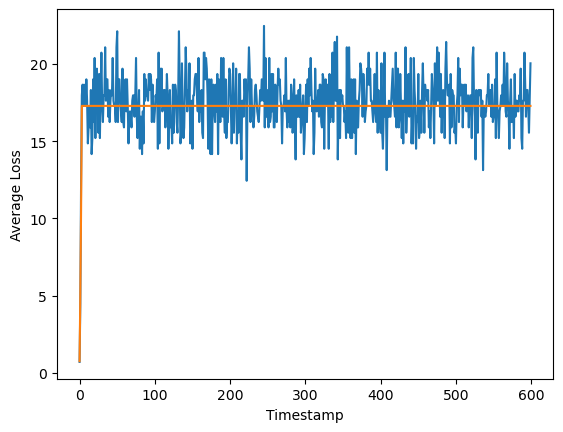

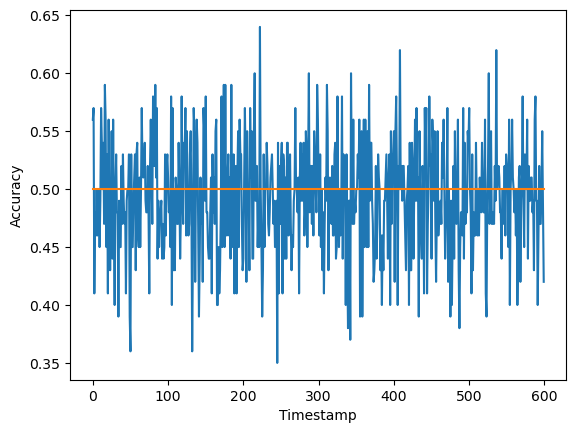

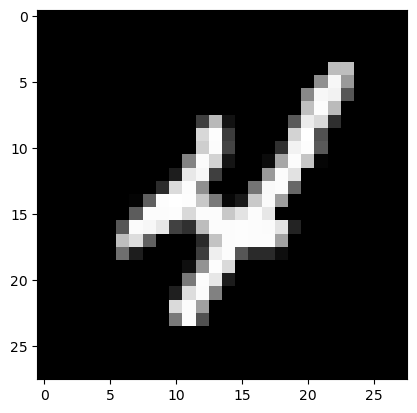

In [28]:
# i
# Plot the train and test losses from the MNIST network with step size = 0.1
# YOUR CODE HERE
plt.plot(train_loss)
plt.plot(test_loss)
plt.xlabel('Timestamp')
plt.ylabel('Average Loss')
plt.show()
# ii
# Plot the train and test accuracies from the MNIST network with step size = 0.1
# YOUR CODE HERE
plt.plot(train_acc)
plt.plot(test_acc)
plt.xlabel('Timestamp')
plt.ylabel('Accuracy')
plt.show()

# iii
# Visualize (plot) some images that are misclassified by your network
y_test = y_test.reshape(-1,1)
correct = (finalout_test == y_test)
false = np.where(correct == False)
display_image(mnist.train_images()[false[0][4]])

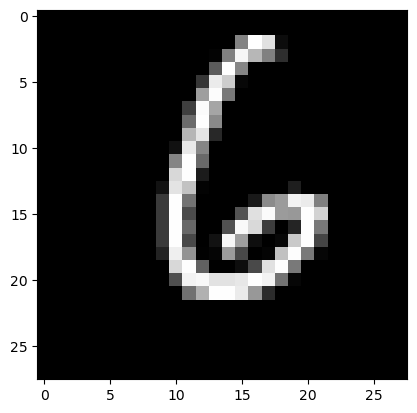

In [29]:
display_image(mnist.train_images()[false[0][13]])

1.3e iii:
Examine the images that your network guesses incorrectly, and explain at a high level
what patterns you see in those images.

The handwriting of these images are pretty ambiguous. The shape of the number look like another number. So from the computer point of view, it can only detect the place where the pixel exist. It will falsely classify it.

1.3e iv:
Rerun the neural network training but now increase the step size to 10.0. What happens?
You do not need to include plots here.

The model doesn't converge to a local minimum because we overshoot it every time. Large step size diverges.

1.3f (optional) (Train a network to fit 100 random images to the first 100 original labels! How fast can you memorize the dataset?)

In [15]:
X_train = np.random.rand(100, 784)
# YOUR CODE HERE